### Objective
- Evaluate the effectiveness of a trial run in stores 77, 86, and 88. 

- Compare these trial stores to control stores over a trial period (2019-02 to 2019-04) to see if the trial caused a meaningful change.

In [66]:
# importing dataset
import pandas as pd

data = pd.read_csv(r"D:\projects\RetailTrialImpactAnalysis\2nd_Sprint\QVI_data.csv",header=0)
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [67]:
# Renaming columns
data.columns = [
    'LoyalityCardNumber', 'Date', 'StoreNumber', 'TransactionID', 'ProductNumber', 'ProductName',
    'ProductQuantity', 'TotalSales', 'PackSize', 'Brand', 'LifeStage', 'PremiumCustomer'
]

#### Aggregate Monthly Metrics

In [68]:
data['Date'] = pd.to_datetime(data['Date'])
data['YearMonth'] = data['Date'].dt.to_period('M')

# group by store and month
monthlyMetrics = data.groupby(['StoreNumber','YearMonth']).agg(
    totalSales=('TotalSales', 'sum'),
    uniqueCustomers=('LoyalityCardNumber', 'nunique'),
    totalTransactions=('TransactionID', 'nunique')
).reset_index()

# average transactions per customer
monthlyMetrics['avgTxnPerCustomer'] = (monthlyMetrics['totalTransactions'] / monthlyMetrics['uniqueCustomers'])

monthlyMetrics.head(15)

,StoreNumber,YearMonth,totalSales,uniqueCustomers,totalTransactions,avgTxnPerCustomer
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739
5,1,2018-12,189.6,42,47,1.119048
6,1,2019-01,154.8,35,36,1.028571
7,1,2019-02,225.4,52,55,1.057692
8,1,2019-03,192.9,45,49,1.088889
9,1,2019-04,192.9,42,43,1.023810


In [69]:
monthlyMetrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   StoreNumber        3169 non-null   int64    
 1   YearMonth          3169 non-null   period[M]
 2   totalSales         3169 non-null   float64  
 3   uniqueCustomers    3169 non-null   int64    
 4   totalTransactions  3169 non-null   int64    
 5   avgTxnPerCustomer  3169 non-null   float64  
dtypes: float64(2), int64(3), period[M](1)
memory usage: 148.7 KB


#### Define a Similarity Metric
**Goal:** Select a control store for each trial store (77, 86, 88) by comparing pre-trial metrics (sales, customers, transactions) between all stores.

In [70]:
preTrial = monthlyMetrics[monthlyMetrics['YearMonth'] < "2019-02"]

def computeSimilarity(trialStore):
    storeList = preTrial['StoreNumber'].unique()
    storeList = storeList[storeList != trialStore]
    corrs = []
    
    trial = preTrial[preTrial['StoreNumber'] == trialStore][['YearMonth', 'totalSales', 'uniqueCustomers', 'totalTransactions']]
    
    for store in storeList:
        control = preTrial[preTrial['StoreNumber'] == store][['YearMonth', 'totalSales', 'uniqueCustomers', 'totalTransactions']]
        merged = pd.merge(trial, control, on='YearMonth', suffixes=('_trial', '_control'))
        
        if len(merged) < 6:
            continue 
        
        merged_clean = merged.dropna()
        totalSalesCorr = merged_clean['totalSales_trial'].corr(merged_clean['totalSales_control'])
        custCountCorr = merged_clean['uniqueCustomers_trial'].corr(merged_clean['uniqueCustomers_control'])
        totalTxnCorr = merged_clean['totalTransactions_trial'].corr(merged_clean['totalTransactions_control'])
        
        finalScore = (totalSalesCorr + custCountCorr + totalTxnCorr) / 3
        
        corrs.append({
            'trial_store': trialStore,
            'control_store': store,
            'corr_sales': totalSalesCorr,
            'corr_customer': custCountCorr,
            'corr_txn': totalTxnCorr,
            'similarity_score': finalScore
        })

    similarityDF = pd.DataFrame(corrs)
    bestControl = similarityDF.sort_values(by='similarity_score', ascending=False).head(1)
    print(f"Best control store for trial store {trialStore} is:")
    print(bestControl)
    #return similarityDF, bestControl


In [71]:
for trial in [77, 86, 88]:
    computeSimilarity(trial)


Best control store for trial store 77 is:
     trial_store  control_store  corr_sales  corr_customer  corr_txn  \
223           77            233    0.903774       0.990358  0.958422   

     similarity_score  
223          0.950851  
Best control store for trial store 86 is:
     trial_store  control_store  corr_sales  corr_customer  corr_txn  \
148           86            155    0.877882       0.942876  0.642294   

     similarity_score  
148          0.821017  
Best control store for trial store 88 is:
    trial_store  control_store  corr_sales  corr_customer  corr_txn  \
12           88             14    0.698557       0.942976  0.836849   

    similarity_score  
12          0.826128  


#### Compare Trial vs Control During Trial Period

In [72]:
import matplotlib.pyplot as plt

trialPeriod = monthlyMetrics[monthlyMetrics['YearMonth'].between('2019-02', '2019-04')]

# defining function for comparison
def compareTrialControl(trialStore, controlStore, plot=False):
    trial = trialPeriod[trialPeriod['StoreNumber'] == trialStore].sort_values(by='YearMonth')
    control = trialPeriod[trialPeriod['StoreNumber'] == controlStore].sort_values(by='YearMonth')
    
    # total sales comparison
    salesIncrease = (trial['totalSales'].sum() - control['totalSales'].sum())
    print(f"Total Sales Increase: ${salesIncrease:.2f}")
    
    # unique customer comparison
    custIncrease = (trial['uniqueCustomers'].sum() - control['uniqueCustomers'].sum())
    print(f"Extra Customers: {custIncrease}")
    
    # average transactions per customer comparison
    avg_txn_diff = (trial['avgTxnPerCustomer'].mean() - control['avgTxnPerCustomer'].mean())
    print(f"Difference in Avg Transactions per Customer: {avg_txn_diff:.2f}")
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(trial['YearMonth'].astype(str), trial['totalSales'], label=f'Trial Store {trialStore}', marker='o')
        plt.plot(control['YearMonth'].astype(str), control['totalSales'], label=f'Control Store {controlStore}', marker='o')
        plt.title('Total Sales Comparison During Trial Period')
        plt.xlabel('Month')
        plt.ylabel('Total Sales')
        plt.legend()
        plt.grid(True)
        plt.show()

Total Sales Increase: $4221.90
Extra Customers: 376
Difference in Avg Transactions per Customer: 0.25


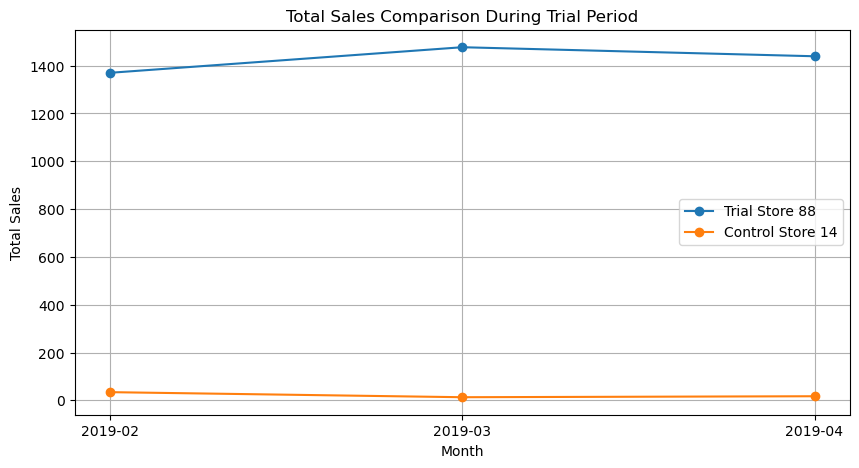

Total Sales Increase: $248.00
Extra Customers: 39
Difference in Avg Transactions per Customer: -0.03


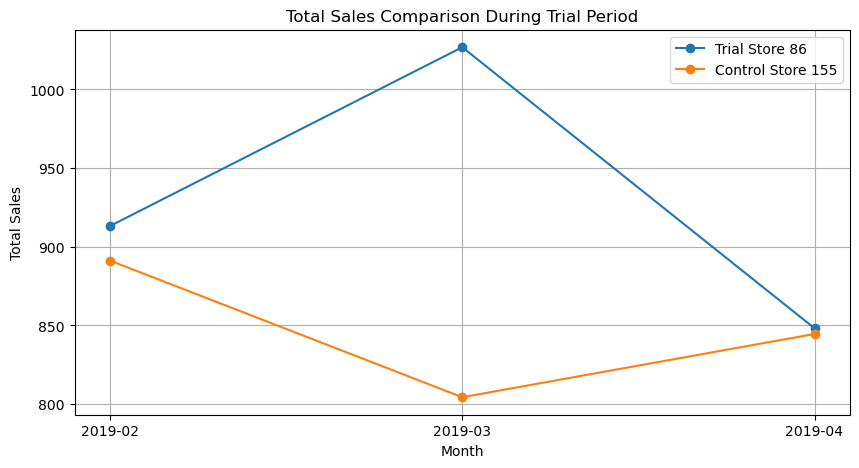

Total Sales Increase: $175.30
Extra Customers: 27
Difference in Avg Transactions per Customer: -0.00


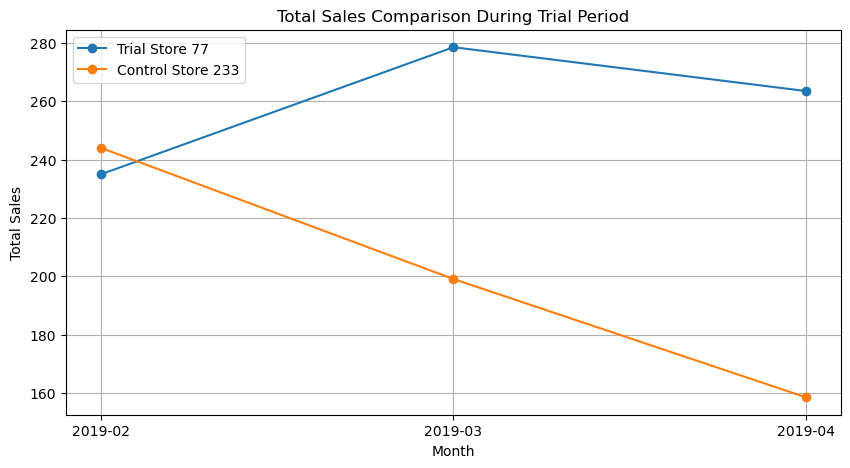

In [73]:
control_map = { 88: 14, 86: 155, 77: 233}
results = []

for trial, control in control_map.items():
    compareTrialControl(trial, control, plot=True)

### Conclusion
**Trial Store 88 vs Control Store 14**
- There was a significant increase in total sales during the trial.
- The large number of extra customers (376) suggests that the increase is mostly due to more customers visiting the store, rather than existing customers buying more.
- The increase in transactions per customer (0.25) also indicates that customers may have bought more frequently than in the control store.

**Trial Store 86 vs Control Store 155**
- A small increase in total sales and customers.
- The decrease in transactions per customer indicates that the sales boost came from new customers, not from existing customers buying more often.
- Almost a weak trial effect.

**Trial Store 77 vs Control Store 233**
- Minimal Impact.
- The customer count rose slightly, but there's no change in how often customeres transacted.
- This trial was not that successful.

**Trial Store 88 showed the most positive results and should be used as a case study for successful implementation.**